# Quantum Diffusion Denoising Probabilsitc Model

### Introduction 

Quantum generative models, empowered by entanglement and superposition, have brought
new insight to learning classical and quantum data. Inspired by the classical counterpart, we propose the quantum denoising diffusion probabilistic model (QuDDPM) to enable efficiently trainable
generative learning of quantum data.

Below, we are simply importing the dependcies we need to carry out this project.

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from scipy.stats import unitary_group
from itertools import combinations
from qutip import Bloch
import matplotlib.pyplot as plt
import scienceplots
from scipy.optimize import minimize
from IPython.display import clear_output

plt.style.use(['science', 'ieee', 'no-latex'])

This section defines the fundamental parameters for the Quantum ML model:

- `n`: Number of primary system qubits.
- `na`: Number of ancillary qubits.
- `n_tot`: Total number of qubits.
- `T`: Total number of diffusion steps.
- `L`: Number of layers in the quantum circuit.
- `Ndata`: Number of data points to be processed.
- `Nparams`: Total number of trainable parameters.

In [2]:
n = 2
na = 1
n_tot = n + na
T = 20
L = 6
Ndata = 100
Nparams = 2 * L * n_tot

### Diffusion Model

The Diffusion Model is a framework used to describe the evolution of quantum states over time,  incorporating noise. An initial quantum state is iteratively modified by applying a specific transformation (scrambling circuit). We start from an ensbmle we wish to copy, in this case its a 1 qubit cluster around the state zero.

We define two functions that are essential for the diffusion model.

- The first serves as the target ensemble we aim to replicate during training.
- The second represents the evolved quantum states after all diffusion steps

In [3]:
def cluster0Gen(n, N_train, scale, seed=None):

    np.random.seed(seed)
    
    # Generate random complex components for the state vectors
    # randn here returns samples from the standard normal distribution
    real_part = np.random.randn(N_train, 2**n - 1) 
    imag_part = np.random.randn(N_train, 2**n - 1)
    random_components = real_part + 1j * imag_part
    
    # Add the fixed first component and scale the random components
    fixed_component = np.ones((N_train, 1)) 
    states = np.hstack((fixed_component, scale * random_components))
    
    # Normalise the states to ensure they are valid quantum states
    norms = np.linalg.norm(states, axis=1, keepdims=True)
    states /= norms
    
    return states.astype(np.complex64)

In [4]:
def haarSample(Ndata, seed=None):

    np.random.seed(seed)
    
    # Generate Haar-random quantum states
    states = [
        unitary_group.rvs(2**n)[:, 0]  # first colmn of a Haar random unitary matrix
        for _ in range(Ndata)
    ]
    
    return states

In [5]:
def diffusionCircuit(t, input_state, phis, gs=None):

    qc = QuantumCircuit(n)
    state = Statevector(input_state)

    # Apply parameterized gates for `t` time steps
    for tt in range(t):
        # Apply Rz and Ry rotations to each qubit in each time step
        for i in range(n):
            qc.rz(phis[3 * n * tt + i], i)
            qc.ry(phis[3 * n * tt + n + i], i)
            qc.rz(phis[3 * n * tt + 2 * n + i], i)  #

        # If entangling gates (Rzz) are required and n >= 2, apply them
        if n >= 2 and gs is not None:
            for i, j in combinations(range(n), 2):
                qc.rzz(gs[tt] / (2 * np.sqrt(n)), i, j)
    state = state.evolve(qc)
    return state

In [6]:
def diffusionData(t, inputs, diff_hs, seed):

    np.random.seed(seed) 

    # Generate random rotation angles for the circuit
    phis = (np.random.rand(Ndata, 3 * n * t) * np.pi / 4 - np.pi / 8) * diff_hs.repeat(3 * n)
    
    # Generate entangling gate parameters
    if n > 1: gs = (np.random.rand(Ndata, t) * 0.2 + 0.4) * diff_hs
    else: gs = None

    states = np.zeros((Ndata, 2**n), dtype=np.complex128)

    # Evolve each state using the diffusion circuit
    for i in range(Ndata):
        states[i] = diffusionCircuit(t, inputs[i], phis[i], gs[i] if gs is not None else None).data

    return states


Now, let us visualise the diffusion process. We first generate the initial ensemble of quantum states using the `cluster0Gen` function. Then, we define a scaling factor `diff_hs` and use the `diffusionData` function to evolve the quantum states over multiple time steps, storing the results in the array `S`. This allows us to track the evolution of the ensemble through the diffusion process.

In [7]:
# the diffusion scaling factor
diff_hs = np.linspace(1.0, 4.0, T)

initial_states = cluster0Gen(n, Ndata, 0.08, seed=12)

S = np.zeros((T + 1, Ndata, 2**n), dtype=np.complex64)
S[0] = initial_states

for t in range(1, T + 1):
    S[t] = diffusionData(t, initial_states, diff_hs[:t], seed=t)

In [8]:
def stateToBloch(statevector):
    alpha, beta = statevector[0], statevector[1]
    x = 2 * np.real(alpha * np.conj(beta))
    y = 2 * np.imag(alpha * np.conj(beta))
    z = np.abs(alpha)**2 - np.abs(beta)**2
    
    return x, y, z

### Denoising Model

The denoising model is the other cenrtal part of the QuDDPM. Each denoising step applies a unitary $\tilde{U}_k$ on the system, along with $n_A$ ancilla qubits in the zero state, and performs a projective measurement in the computational basis on the ancilla qubits after applying the unitary.

The `randomMeasure` function simulates a quantum measurement on an input state. It reshapes the state to separate the system and ancilla qubits, then calculates the measurement probabilities based on the squared magnitudes of the reshaped state. A random ancilla state is selected according to these probabilities, and the corresponding post-measurement state is extracted. This state is then normalised to ensure it has unit norm before being returned. The function models the collapse of the quantum state after a measurement and ensures the resulting state remains a valid quantum state

In [10]:
def randomMeasure(input_state):
    reshaped = input_state.reshape(2**na, 2**n)
    m_probs = np.sum(np.abs(reshaped)**2, axis=1)  # probabilities of ancilla states
    #m_probs = m_probs / np.sum(m_probs)

    m_res = np.random.choice(len(m_probs), p=m_probs)  # Measure and select an ancilla state
    indices = 2**n * m_res + np.arange(2**n)  # Index of post-measurement state

    post_state = input_state[indices]  # Select the corresponding post-measurement state

    norm = np.linalg.norm(post_state)

    normalized_state = post_state / norm
    return normalized_state

In [11]:
def denoisingLayer(input_state, params, n_tot, L):
  
    state = Statevector(input_state)

    qc = QuantumCircuit(n_tot)

    # Apply layers of gates
    for l in range(L):
        for i in range(n_tot):
            qc.rx(params[2 * n_tot * l + i], i)
            qc.ry(params[2 * n_tot * l + n_tot + i], i)
        for i in range(n_tot // 2):
            qc.cz(2 * i, 2 * i + 1)
        if n_tot % 2 == 1: 
            qc.cz(n_tot - 2, n_tot - 1)

    state = state.evolve(qc)

    return randomMeasure(state.data)

In [12]:
anc = np.zeros(2**na)
anc[0] = 1

def denoisingFull(input_state, params, n_tot, L, t):
    x = []
    x.append(input_state) 
    for t in range(T,t-1,-1):
        p = params[(T-t) * Nparams : (T-t+1) * Nparams]
        outcome = denoisingLayer(x[-1], p, n_tot, L)
        x.append(np.kron(outcome[outcome!=0], anc))
    return x[-1]

In [13]:
def maxMeanDiscripency(set1, set2):
    set1 = np.array(set1, dtype=np.complex128)
    set2 = np.array(set2, dtype=np.complex128)
    
    r11 = 1 - np.mean(np.abs(set1 @ set1.conj().T)**2)
    r22 = 1 - np.mean(np.abs(set2 @ set2.conj().T)**2)
    r12 = 1 - np.mean(np.abs(set1 @ set2.conj().T)**2)
    return 2 * r12 - r11 - r22

### Training the Model

In [14]:
ApproxS = [None] * (T+1)
ApproxS[-1] = haarSample(Ndata,seed=22)

In [15]:
loss_hist = []

theta = np.random.uniform(0,2*np.pi, T * Nparams)

def costFunction(params, t):
    output = []
    ApproxS[t-1] = []
    for i in range(Ndata):
        input = np.kron(ApproxS[t][i], anc)
        #input = input / np.linalg.norm(input)
        #temp = denoisingFull(input, np.array(theta[0: (T-t+1) * Nparams]), n_tot, L, t+1)
        #output.append(denoisingLayer(temp, np.array(params), n_tot, L))
        #output[i] = output[i] / np.linalg.norm(output[i])
        output = denoisingLayer(input, np.array(params), n_tot, L)
        ApproxS[t-1].append(output[output!=0])

    cost = maxMeanDiscripency(ApproxS[t-1], S[t-1])
    loss_hist.append(cost)

    # Clear output and update the real-time plot
    clear_output(wait=True)
    plt.xlabel("Training Step")
    plt.yscale("log")
    plt.ylabel(r"$\mathcal{D}_{\text{MMD}} (\tilde{\mathcal{S}}_t, \mathcal{S}_t)$")
    plt.plot(range(len(loss_hist)), loss_hist, color='k')
    plt.title(f"Current Step: {t}")
    plt.show()

    return cost

In `scipy.optimize.minimize()`, the function will return the best value it found during the optimisation process, not necessarily the most recent value evaluated.

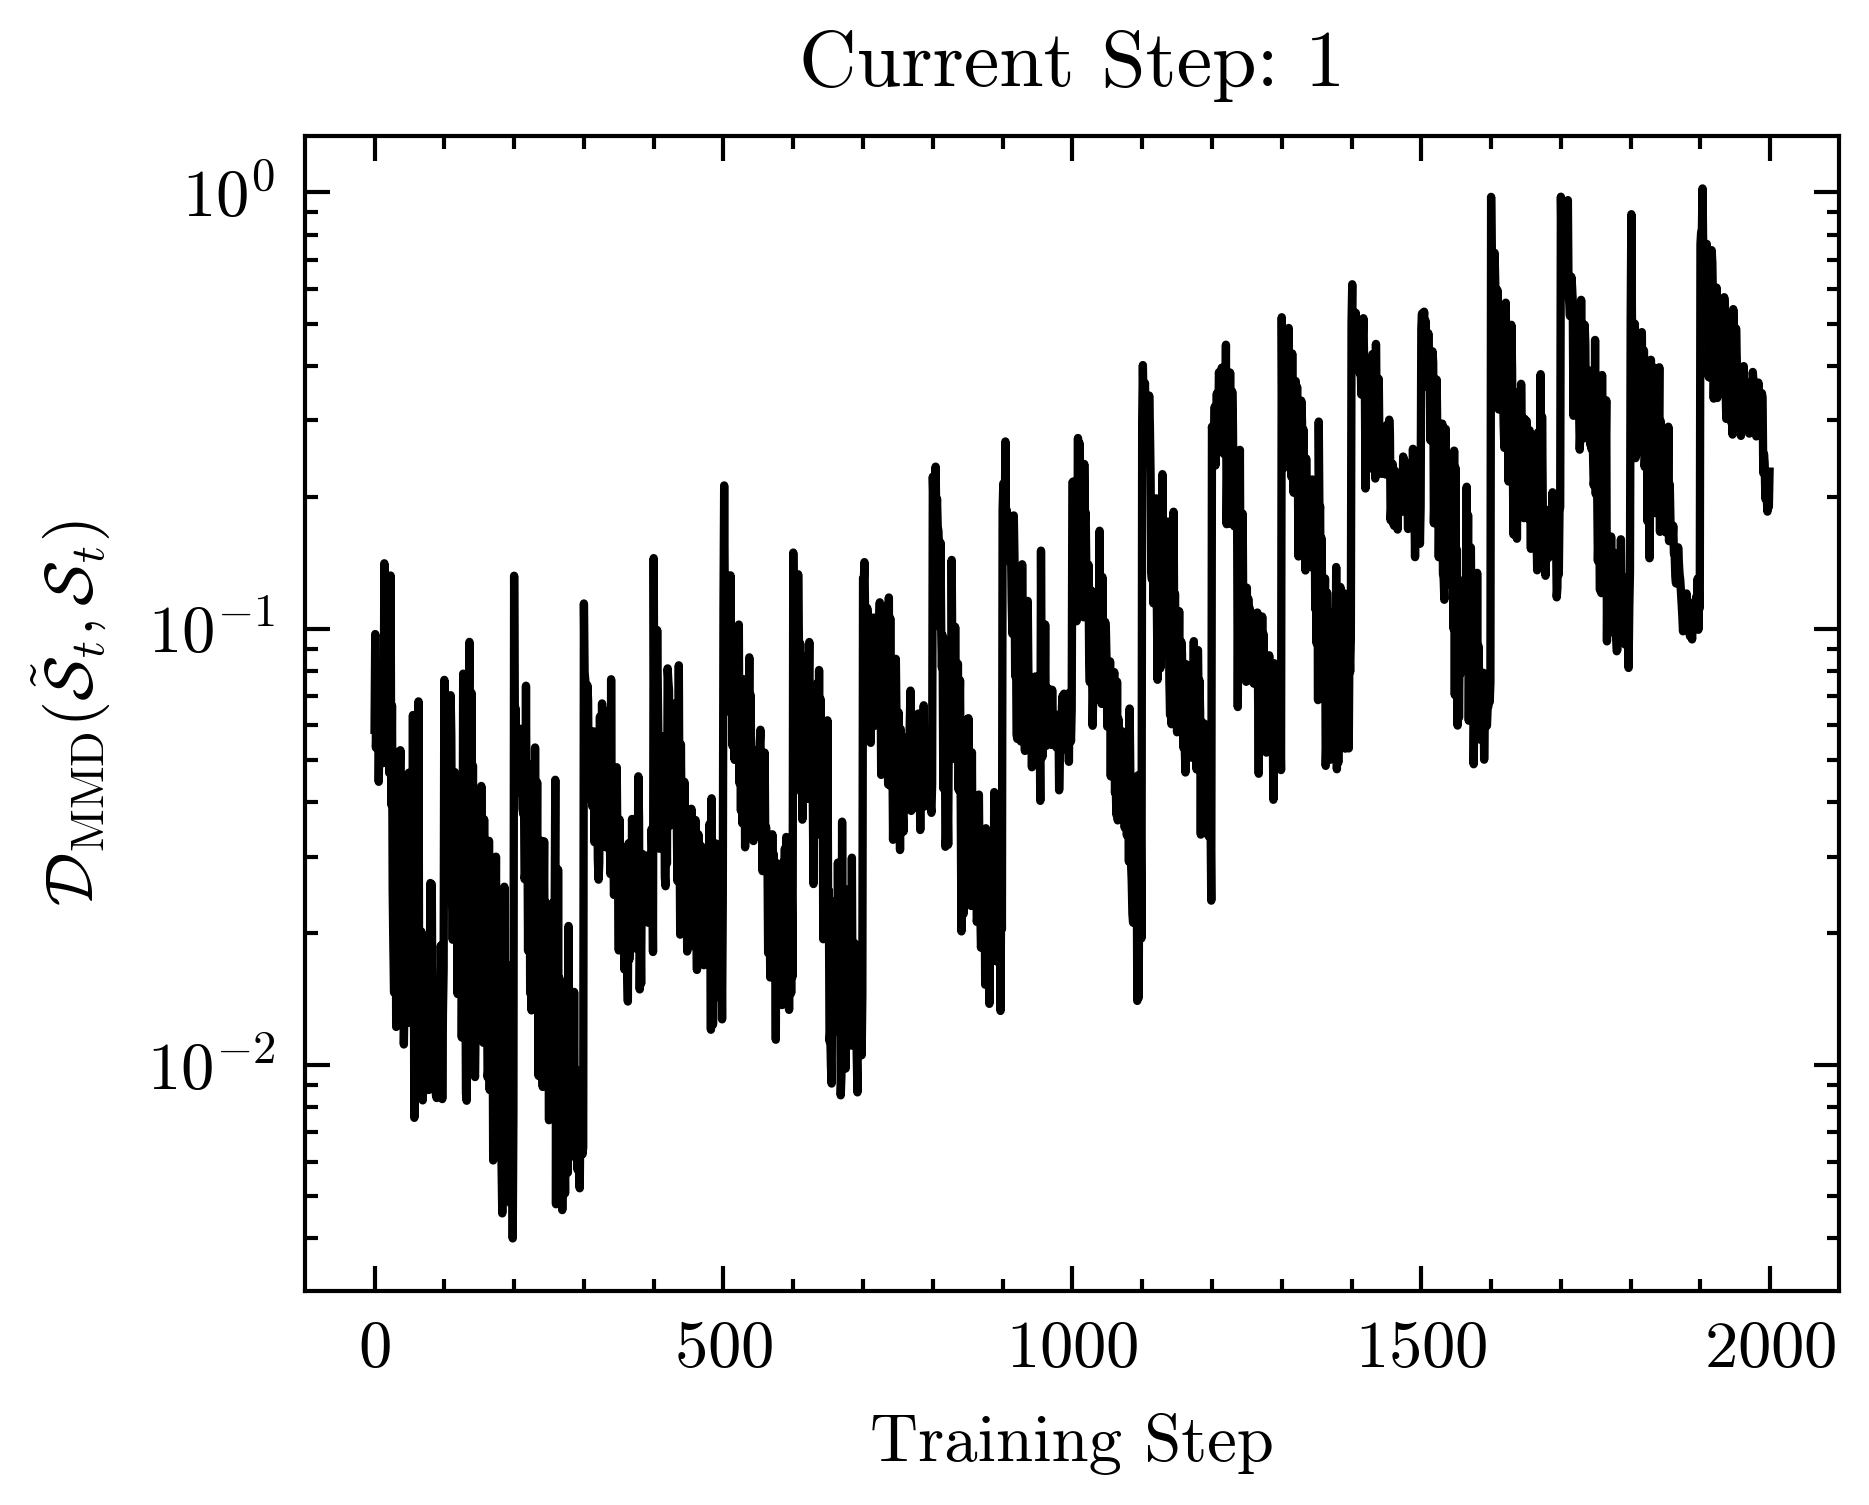

In [16]:
# Loop over time steps in reverse (from T to 1)
for k in np.arange(T, 0, -1):

    result = minimize(
        costFunction,
        theta[(T - k) * Nparams: (T - k + 1) * Nparams],
        args=(k,),
        method="COBYLA",
        options={"maxiter": 100, 'tol': 1e-10},
    )
    theta[(T - k) * Nparams: (T - k + 1) * Nparams] = result.x

/var/folders/z8/g5m0xfqn4nx8cgfn199lgfq40000gn/T/ipykernel_7209/2092687671.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  secax.set_xticklabels(np.arange(T+5,-1,-5))


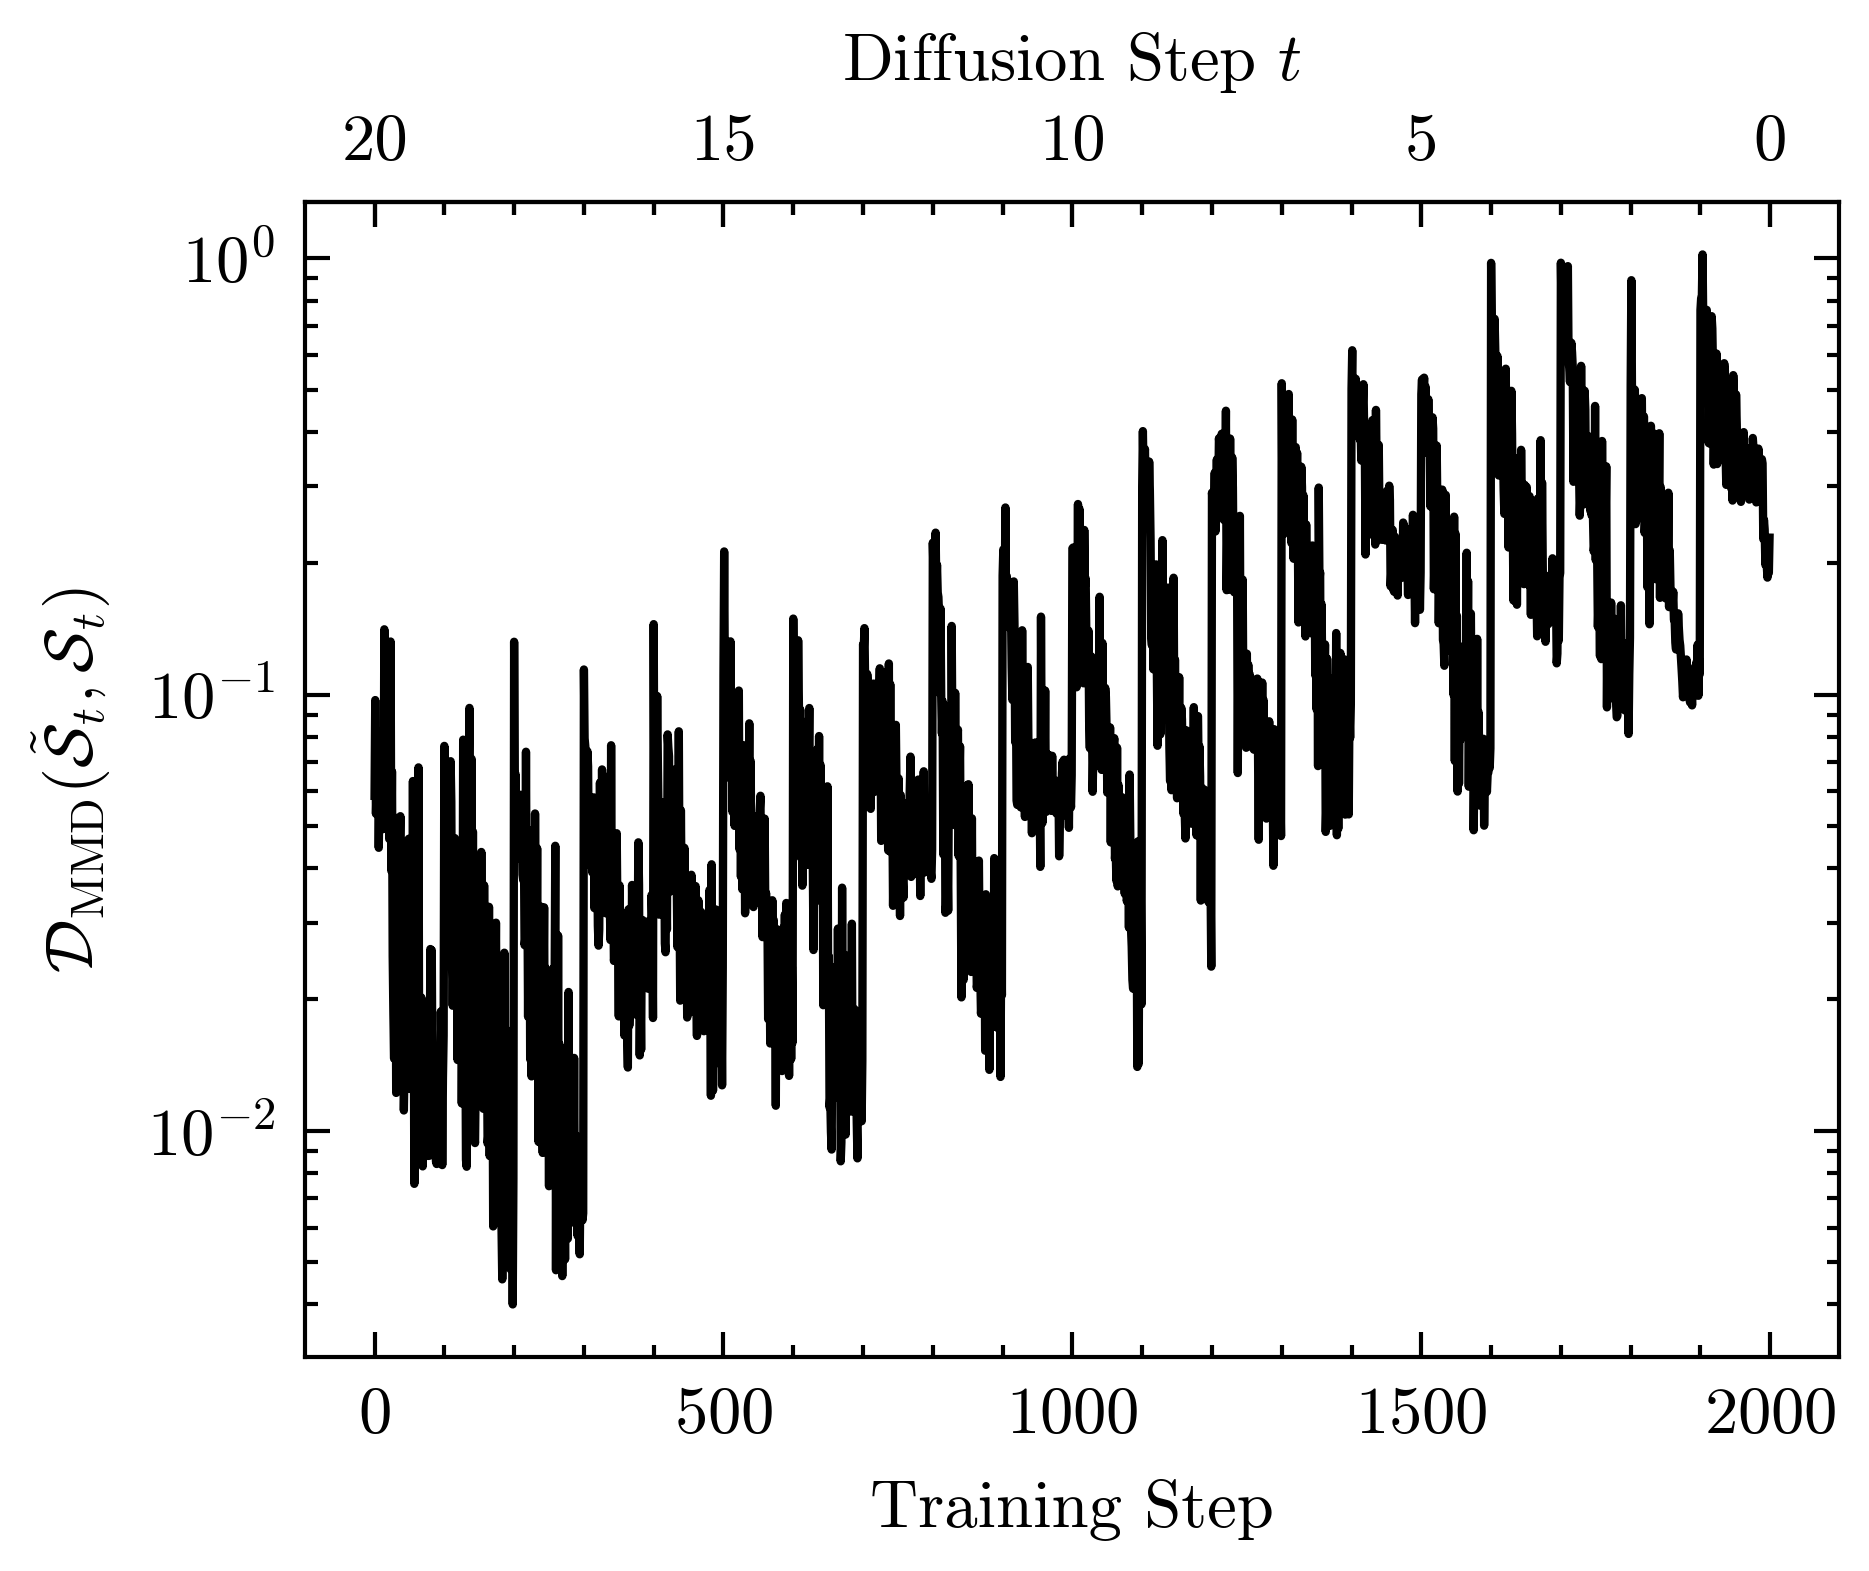

In [21]:
plt.xlabel("Training Step")
plt.yscale('log')
plt.ylabel(r'$\mathcal{D}_{\text{MMD}} (\tilde{\mathcal{S}}_t, \mathcal{S}_t)$')
plt.plot(range(len(loss_hist)), loss_hist, color='k')

secax = plt.gca().secondary_xaxis('top')
secax.set_xlabel(fr"Diffusion Step $t$")
secax.set_xticklabels(np.arange(T+5,-1,-5))
plt.savefig('Clustering-Loss-2qubit.pdf', bbox_inches='tight')

### Testing and Visualisation

In [18]:
testS = [None] * (T+1)

testS[T] = haarSample(Ndata, seed=24)

for t in range(T,0,-1):
    testS[t-1] = []
    for i in range(Ndata):
        input = np.kron(testS[T][i], anc)
        input = input / np.linalg.norm(input)
        temp = denoisingFull(input, np.array(theta[0: (T-t+1) * Nparams]), n_tot, L, t)
        testS[t-1].append(temp[temp!=0])

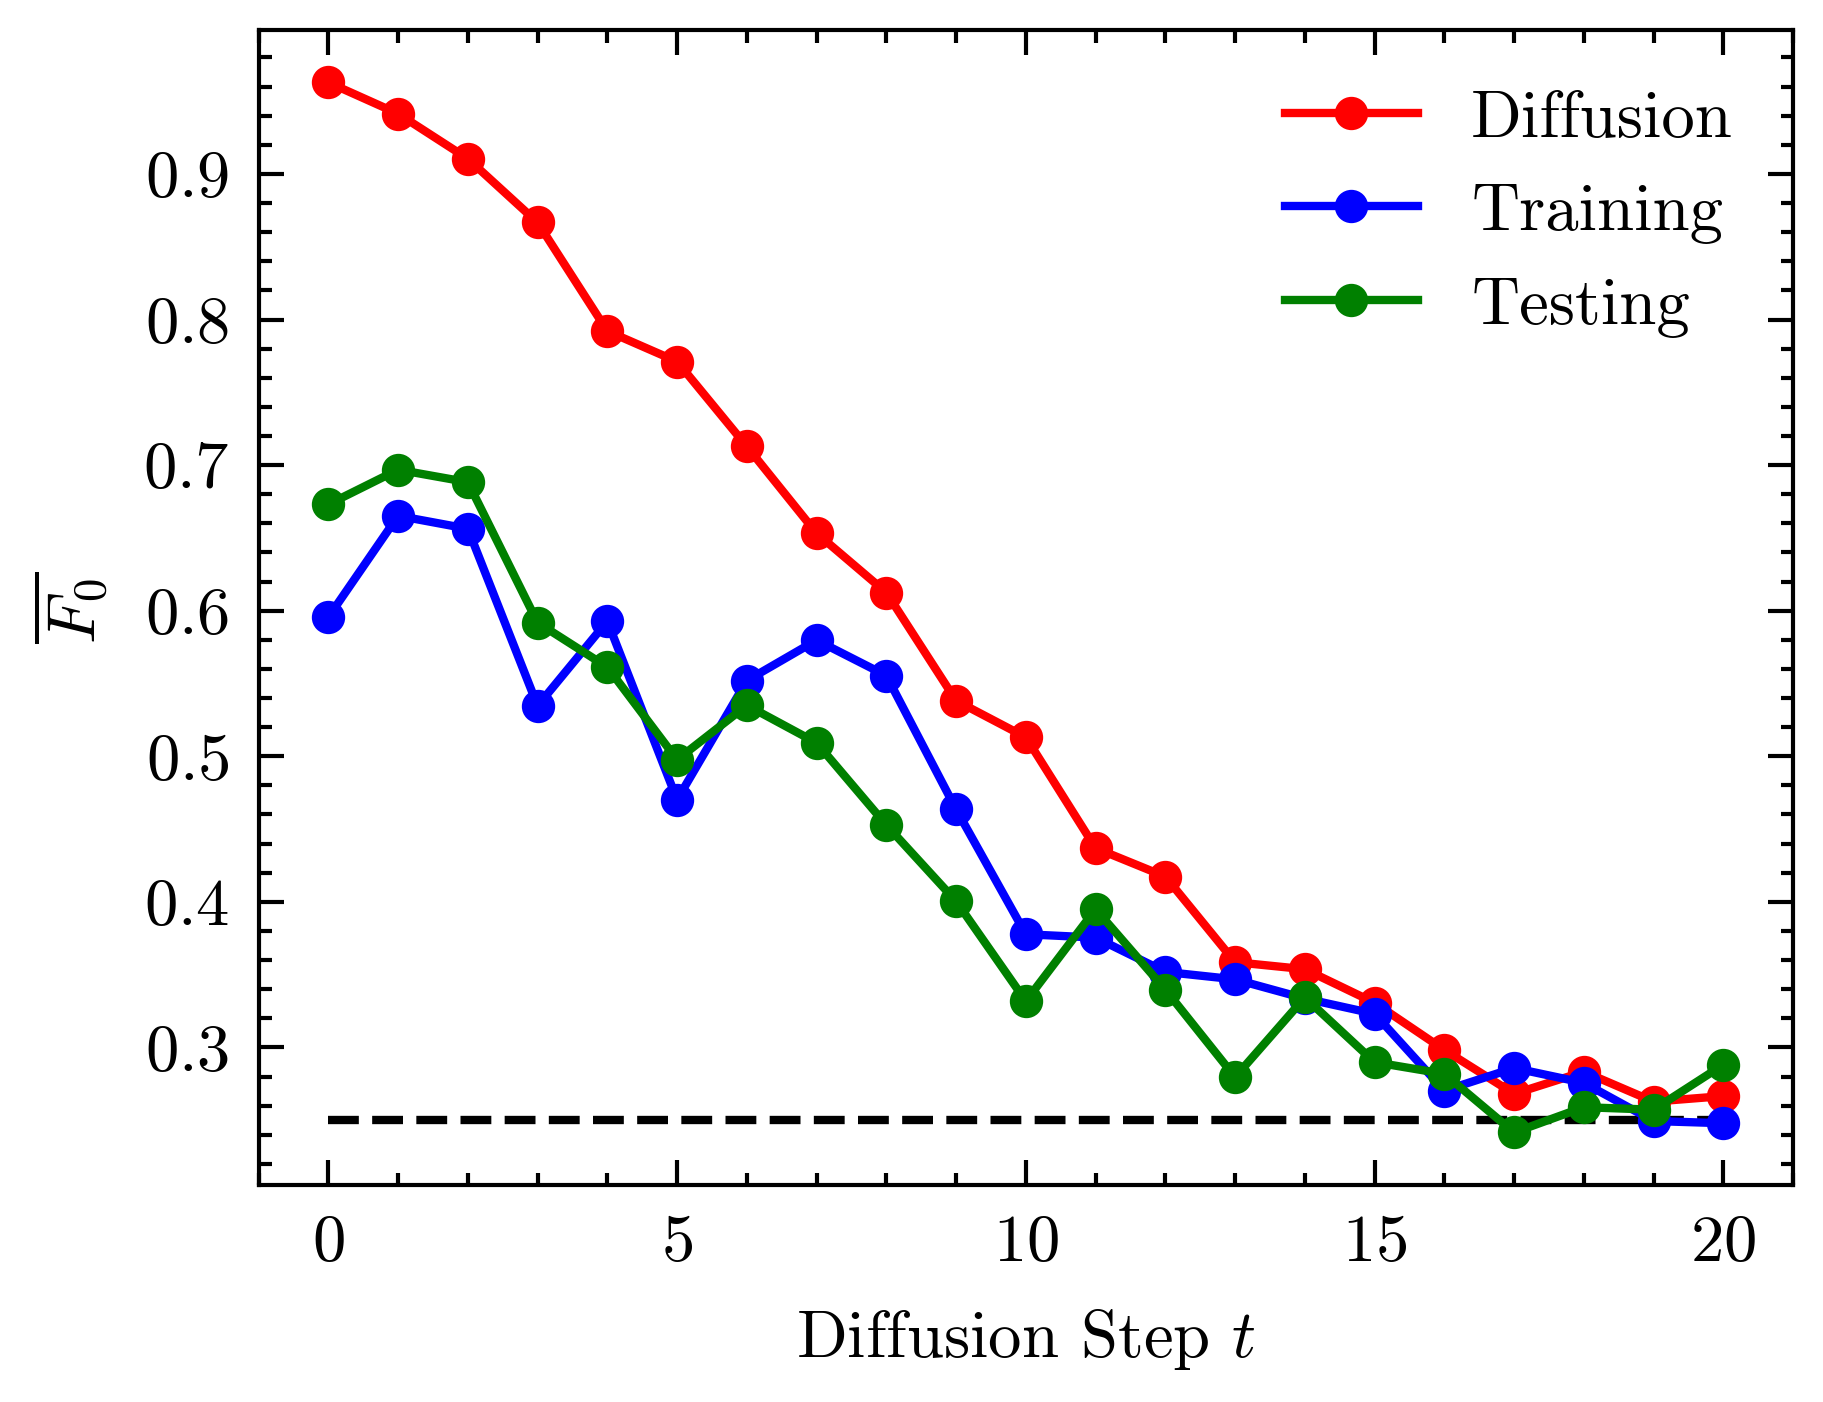

In [22]:
fig, ax = plt.subplots()
ax.plot(range(T+1), [0.25] * (T+1), 'k--')
ApproxS = np.array(ApproxS)
testS = np.array(testS)

ax.plot(range(T+1), np.mean(np.abs(S[:,:,0])**2, axis=1), 'ro-', label=r'Diffusion', markersize=3)
ax.plot(range(T+1), np.mean(np.abs(ApproxS[:,:,0])**2, axis=1), 'bo-', label=r'Training', markersize=3)
ax.plot(range(T+1), np.mean(np.abs(testS[:,:,0])**2, axis=1), 'go-', label=r'Testing', markersize=3)
ax.set_ylabel(r'$\overline{F_0}$')
ax.set_xlabel(r'Diffusion Step $t$')
ax.legend(loc= 'best')
plt.savefig('Clustering-Fidelity-2qubit.pdf', bbox_inches='tight')


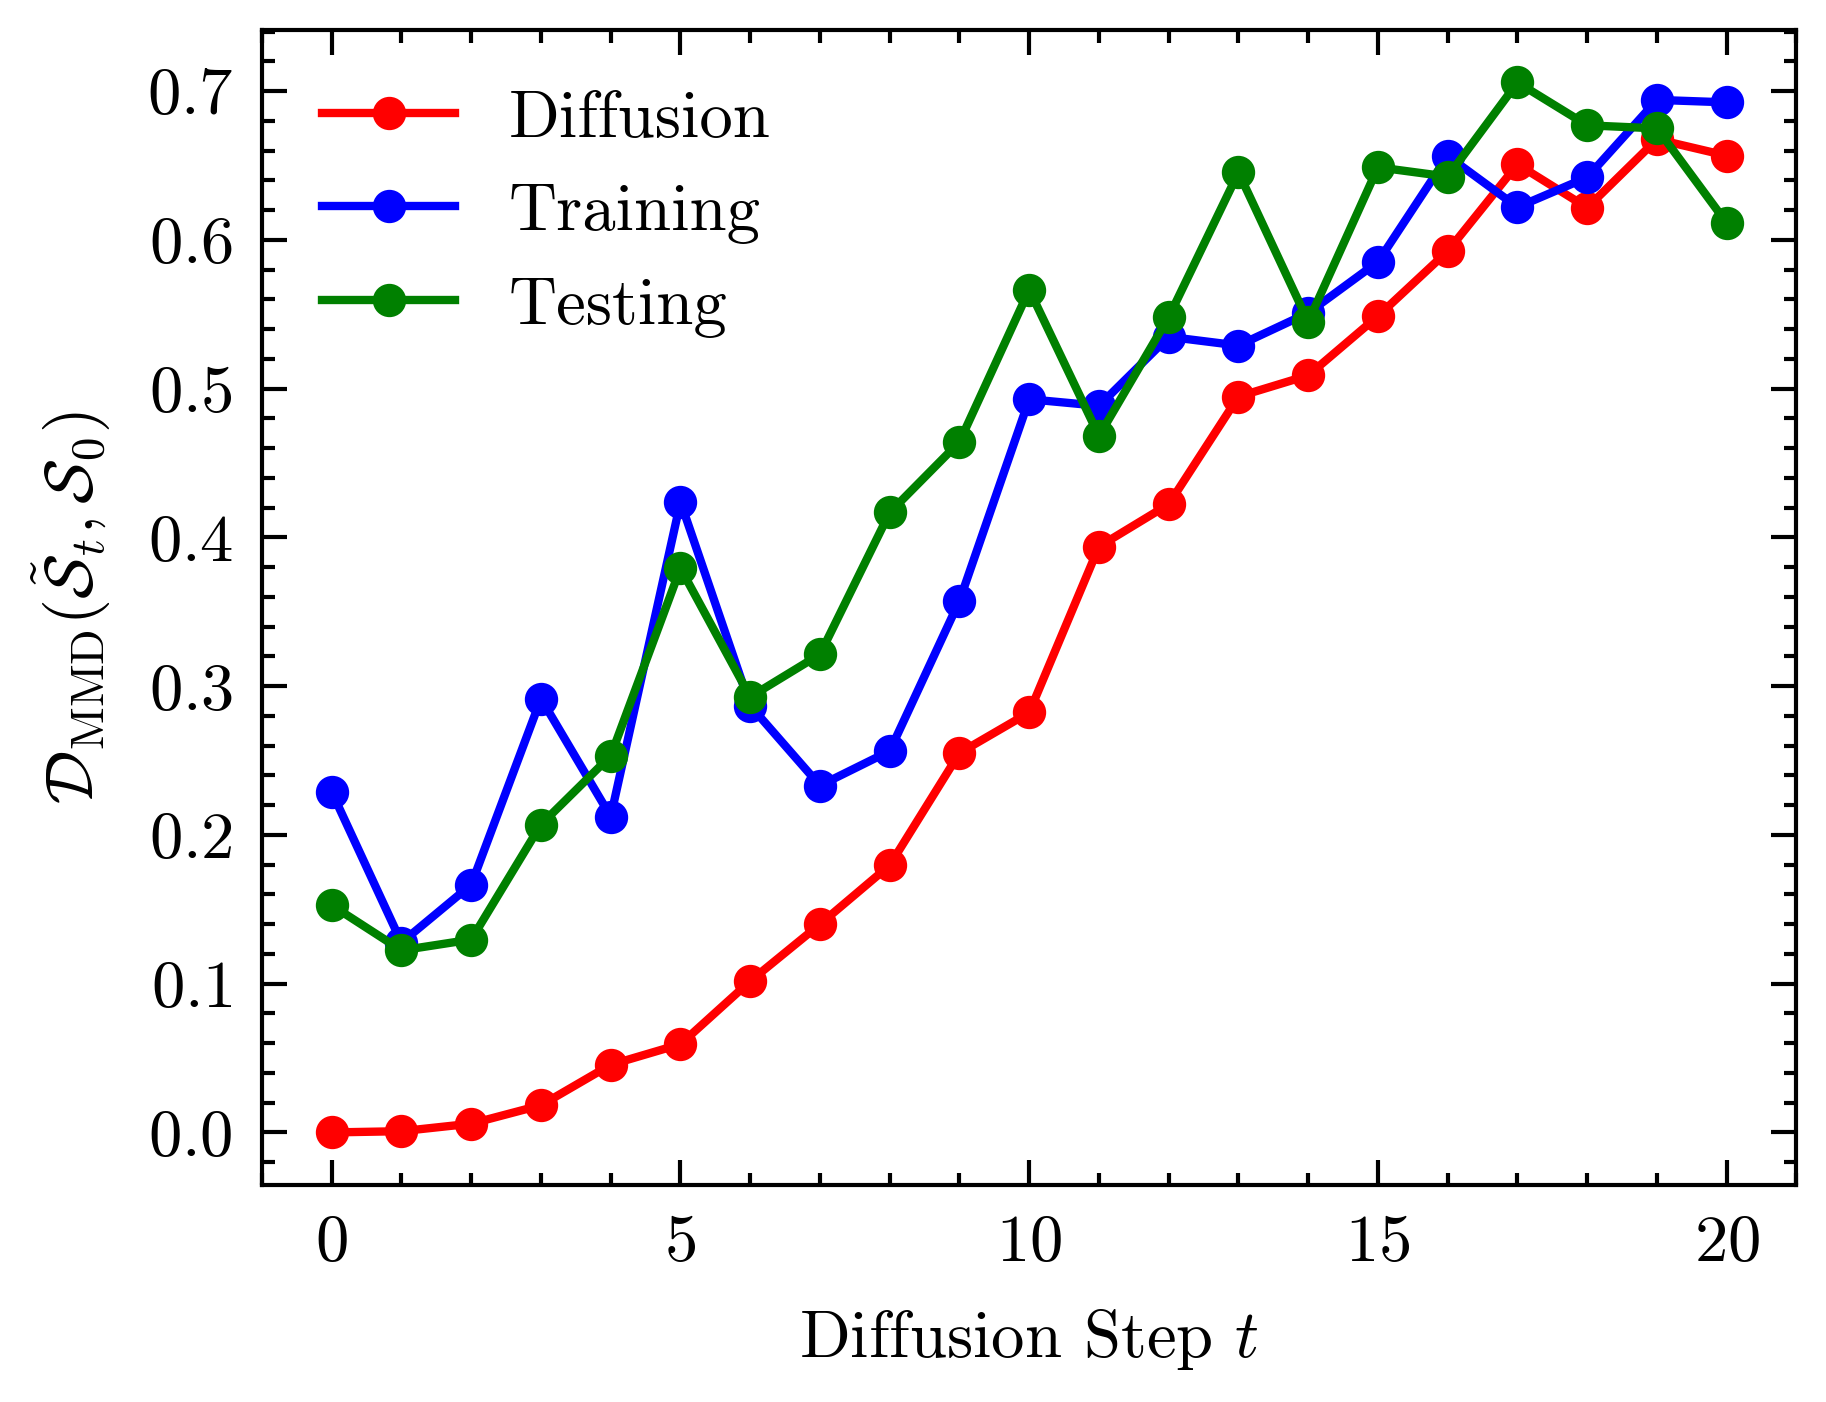

In [20]:
mmds = np.zeros((3, 21))
for t in range(21):
    idx = np.random.choice(S.shape[1], size=100, replace=False)
    mmds[0, t] = maxMeanDiscripency(S[0], S[t, idx])
    mmds[1, t] = maxMeanDiscripency(S[0], ApproxS[t])
    mmds[2, t] = maxMeanDiscripency(S[0], testS[t])

fig, ax = plt.subplots()
ax.plot(mmds[0], 'o-', c='r', label=r'Diffusion',markersize=3)
ax.plot(mmds[1], 'o-', c='b', label=r'Training',markersize=3)
ax.plot(mmds[2], 'o-', c='g', label=r'Testing',markersize=3)

ax.legend(loc = 'best')
ax.set_xlabel(r'Diffusion Step $t$')
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD}(\tilde{\mathcal{S}}_t, \mathcal{S}_0)$')
plt.savefig('Clustering-DistanceInitial-2qubit.pdf', bbox_inches='tight' )